# 02 - Entropy Rate Plots

## Imports

In [1]:
import avn.syntax as syntax
import avn.plotting as plotting
import avn.dataloading as dataloading

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [2]:
from scipy.io import wavfile
import librosa
import re
import scipy.signal
import pandas as pd
class SongFile:
    """
    Data and metadata pertaining to a single audio file.
    
    
    Attributes
    ----------
    data: ndarray
        Contains audio data of wavfile. 
    
    sample_rate: int
        Sample rate of song data. Based on native sample rate of wavfile.
    
    duration: float
        Duration of the audio file in seconds. 
    
    file_path: str
        Path to the local .wav file used to instantiate the SongFile object.
    
    Methods
    -------
    bandpass_filter(lower_cutoff, upper_cutoff)
        Applies a hamming window bandpass filter to the audio data. 
    
    """
    def __init__(self, file_path):
        """
        Parameters
        ----------
        file_path : str
            Path to the local .wav file to be loaded as a SongFile object.
             
        """
        self.sample_rate, self.data = wavfile.read(file_path)
        self.data = self.data.astype(float)
        self.duration = librosa.get_duration(y = self.data, sr = self.sample_rate)
        self.file_path = file_path
        
        #get file name -- This may be windows specific. 
        file_name_regex = re.compile("\\\\")
        self.file_name = file_name_regex.split(self.file_path)[-1]
                                                  
    def bandpass_filter(self, lower_cutoff, upper_cutoff):
        """
        Applies a hamming window bandpass filter to the audio data.

        Parameters
        ----------
        lower_cutoff : int
            Lower cutoff frequency in Hz for the filter. 
        upper_cutoff : int
            Upper cutoff frequency in Hz for the filter. 

        Returns
        -------
        None.

        """
        #create hamming window filter
        filter_bandpass = scipy.signal.firwin(101, cutoff = [lower_cutoff, upper_cutoff], 
                                              fs = self.sample_rate, 
                                              pass_zero = False)
        #apply filter to audio data
        self.data = scipy.signal.lfilter(filter_bandpass, [1.0], self.data)

In [3]:
dataloading.SongFile = SongFile

## Compile List of Birds

In [4]:
All_Birds = ["B145", "B236", "B258", "B385", "B402", "B447", 
             "B507", "G255", "G397", "G402", "G413", "G437", 
             "G439", "G524", "G528", "O144", "O254", "O421", 
             "O440", "O512", "R402", "R425", "R469", "S132", 
             "S421", "S525", "S528", "Y389", "Y397", "Y425", 
             "Y440", "B524", "O434", "Y433", "Y453"] 

#All_Birds should contain 35 bird IDs. Check: 
len(All_Birds)

35

## Calculate Entropy Rates with UMAP + WSEG Labels

In [6]:
bird_level_syntax_full = pd.DataFrame()

for Bird_ID in All_Birds:
    
    path_to_syll_df = "E:\\Final_Bird_Dataset\\UMAP_WSeg_labels_updated\\" + Bird_ID + '_labels.csv'
    syll_df = pd.read_csv(path_to_syll_df)

    if 'files_y' in syll_df.columns:
        syll_df['files'] = syll_df.files_y

    syll_df = syll_df[~syll_df.files.isna()]
    syntax_data = syntax.SyntaxData(Bird_ID, syll_df)

    song_folder_path = 'C:\\Grad_School\\Code_and_software\\Py_code\\March_2021_redo\\redo_data\\labeled_songs\\' 

    syntax_data.add_file_bounds(song_folder_path)
    syntax_data.add_gaps(min_gap = 0.2)
    syntax_data.drop_calls()
    syntax_data.make_transition_matrix()

    entropy_rate = syntax_data.get_entropy_rate()
    entropy_rate_norm = entropy_rate / np.log2(len(syntax_data.unique_labels) + 1)

    curr_df = pd.DataFrame({'Bird_ID' : Bird_ID,  
                            'entropy_rate' : [entropy_rate], 
                            'entropy_rate_norm' : [entropy_rate_norm], 
                            'num_syllables' : [len(syntax_data.unique_labels)]})

    bird_level_syntax_full = pd.concat([bird_level_syntax_full, curr_df])

In [7]:
bird_level_syntax_full.to_csv('bird_level_syntax_wseg_umap.csv')

## Calculate Entropy Rates with Hand Labels

In [8]:
bird_level_syntax_full = pd.DataFrame()

for Bird_ID in All_Birds:
    
    path_to_syll_df = "C:/Grad_School/Code_and_software/Py_code/March_2021_redo/redo_data/labeled_songs/" + Bird_ID + "/" + Bird_ID + "_syll_df_evsonganaly.csv"
    syll_df = pd.read_csv(path_to_syll_df)

    #convert timestamps from milliseconds to seconds
    syll_df['onsets'] = syll_df['onsets'] / 1000
    syll_df['offsets'] = syll_df['offsets'] / 1000
    
    #remove .not.mat file extension from file names in file column
    syll_df['files'] = syll_df['files'].str.split(pat = '.not', n = 1).str[0]
        
    syntax_data = syntax.SyntaxData(Bird_ID, syll_df)

    song_folder_path = 'C:\\Grad_School\\Code_and_software\\Py_code\\March_2021_redo\\redo_data\\labeled_songs\\' 

    syntax_data.add_file_bounds(song_folder_path)
    syntax_data.add_gaps(min_gap = 0.2)
    syntax_data.drop_calls()
    syntax_data.make_transition_matrix()

    entropy_rate = syntax_data.get_entropy_rate()
    entropy_rate_norm = entropy_rate / np.log2(len(syntax_data.unique_labels) + 1)

    curr_df = pd.DataFrame({'Bird_ID' : Bird_ID,  
                            'entropy_rate' : [entropy_rate], 
                            'entropy_rate_norm' : [entropy_rate_norm], 
                            'num_syllables' : [len(syntax_data.unique_labels)]})

    bird_level_syntax_full = pd.concat([bird_level_syntax_full, curr_df])

In [9]:
bird_level_syntax_full.to_csv('bird_level_syntax_hand_labels.csv')

## Compare AVN labels vs. Hand Labels

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [11]:
hand_labels = pd.read_csv('bird_level_syntax_hand_labels.csv')
avn_labels = pd.read_csv('bird_level_syntax_wseg_UMAP.csv')

In [12]:
avn_labels['AVN_er_norm'] = avn_labels.entropy_rate_norm
hand_labels['Hand_er_norm'] = hand_labels.entropy_rate_norm

In [13]:
full_df = pd.merge(hand_labels[['Bird_ID', 'Hand_er_norm']], avn_labels[['Bird_ID', 'AVN_er_norm']], on = 'Bird_ID')
full_df.head()

,Bird_ID,Hand_er_norm,AVN_er_norm
0,B145,0.254501,0.444428
1,B236,0.643662,0.753750
2,B258,0.404360,0.432746
3,B385,0.207545,0.356299
4,B402,0.480421,0.627678


In [14]:
plt.rcParams.update({'font.size': 11})

c:\Users\tkoch\anaconda3\envs\avn4_install_test\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 400x400 with 0 Axes>

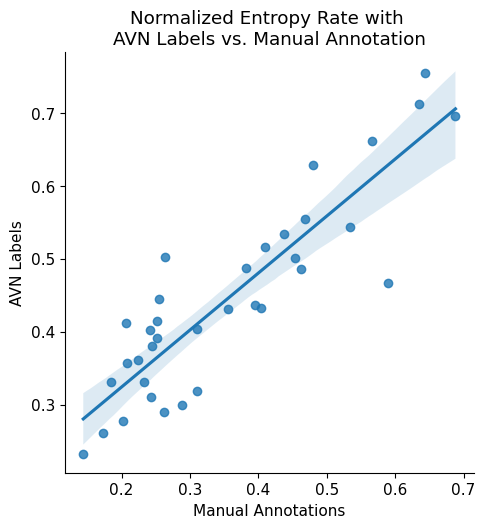

In [15]:
plt.figure(figsize = (4,4))
sns.lmplot(data = full_df, x = 'Hand_er_norm', y = 'AVN_er_norm')
plt.xlabel('Manual Annotations')
plt.ylabel('AVN Labels')
plt.title('Normalized Entropy Rate with \nAVN Labels vs. Manual Annotation')
plt.show()

In [16]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

In [18]:
# linear regression to get slope and r^2
reg = LinearRegression().fit(np.array(full_df['Hand_er_norm'])[:, np.newaxis], full_df['AVN_er_norm'])
print(reg.score(np.array(full_df['Hand_er_norm'])[:, np.newaxis], full_df['AVN_er_norm']))

0.788921864041213


In [19]:
pearsonr(full_df['Hand_er_norm'], full_df['AVN_er_norm'])

(0.8882127358021911, 1.0988227617165504e-12)

## Comparing Groups

In [20]:
all_birds = pd.read_csv("E:\\Final_Bird_Dataset\\old_Bird_list.csv")
full_df = pd.merge(full_df, all_birds[['Bird_ID', 'Condition']], on = 'Bird_ID')

In [21]:
group_dict = {'Isolate' : 'Isolate', 
              'GFP' : 'Normal', 
              'FP1_KD_pre_tut' : 'FP1 KD', 
              'FP1_KD_post_tut' : 'Normal'}
full_df['Group'] = [group_dict[x] for x in full_df.Condition]

### AVN Labels

In [22]:
isolates_AVN = full_df.AVN_er_norm[full_df.Group== 'Isolate']
normal_AVN = full_df.AVN_er_norm[full_df.Group == 'Normal']
FP1_AVN = full_df.AVN_er_norm[full_df.Group == 'FP1 KD']

In [23]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [24]:
fvalue, pvalue = f_oneway(isolates_AVN, normal_AVN, FP1_AVN)
print(fvalue, pvalue)

15.05305664846605 2.4674595021836464e-05


In [25]:
tukey = pairwise_tukeyhsd(endog = full_df['AVN_er_norm'], 
                          groups = full_df['Group'], 
                          alpha = 0.05)

print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
 FP1 KD Isolate  -0.0153 0.9507 -0.1398  0.1091  False
 FP1 KD  Normal  -0.1913 0.0003 -0.2969 -0.0857   True
Isolate  Normal  -0.1759 0.0004 -0.2765 -0.0753   True
------------------------------------------------------


In [26]:
full_df.Group = full_df.Group.astype('category').cat.set_categories(['Normal', 'Isolate', 'FP1 KD'], ordered = True)

(0.2, 0.85)

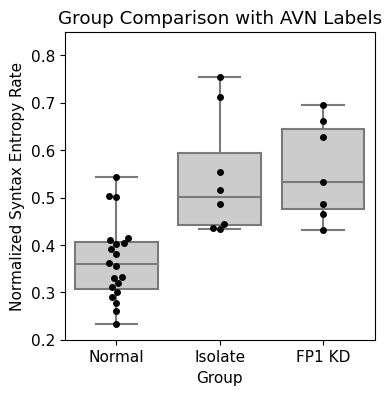

In [28]:
plt.figure(figsize = (4,4))
sns.boxplot(data = full_df, x = 'Group', y = 'AVN_er_norm', color = '0.8')
sns.swarmplot(data = full_df, x = 'Group', y = 'AVN_er_norm', color = 'black', s = 5)
plt.ylabel('Normalized Syntax Entropy Rate')
plt.title('Group Comparison with AVN Labels')
plt.ylim(0.2, 0.85)

## Hand Labels

In [23]:
isolates_Hand= full_df.Hand_er_norm[full_df.Group== 'Isolate']
normal_Hand = full_df.Hand_er_norm[full_df.Group == 'Normal']
FP1_Hand = full_df.Hand_er_norm[full_df.Group == 'FP1 KD']

In [24]:
fvalue, pvalue = f_oneway(isolates_Hand, normal_Hand, FP1_Hand)
print(fvalue, pvalue)

13.453464385263258 5.3346827231377095e-05


In [25]:
tukey = pairwise_tukeyhsd(endog = full_df['Hand_er_norm'], 
                          groups = full_df['Group'], 
                          alpha = 0.05)

print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
 FP1 KD Isolate  -0.0239 0.9096 -0.1649  0.1171  False
 FP1 KD  Normal  -0.2113 0.0003 -0.3292 -0.0933   True
Isolate  Normal  -0.1874 0.0013 -0.3054 -0.0694   True
------------------------------------------------------
